# Demo of Build and Parameterize tools from SwiftPol

- Build a short linear co-polymer chain
- Use [Espaloma Charge](https://github.com/choderalab/espaloma) to assign charges to the SwiftPol chain
- Use a Ring Opening Polymerisation scheme to build a PLGA chain
- Create a small SwiftPol PLGA ensemble
- Test the effect of a uniform and normal distribution on the chain length and % lactide of a SwiftPol PLGA ensemble
- Build a commercially available PLGA chain
- Benchmarking the ensemble build tool

In [10]:
#Leave Notebooks directory
import os
os.chdir("../")

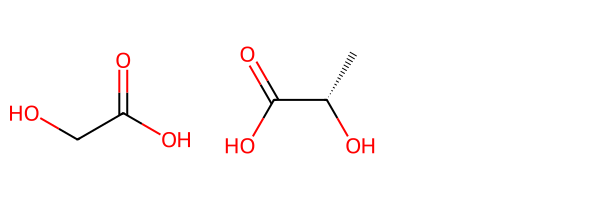

In [11]:
#Import monomers to build PLGA and visualise using RDkit
from rdkit import Chem
monomer_smiles = ['OC(=O)CO', 'C[C@@H](C(=O)[OH])O']
glycolic = Chem.MolFromSmiles(monomer_smiles[0])
lactate = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic,lactate])

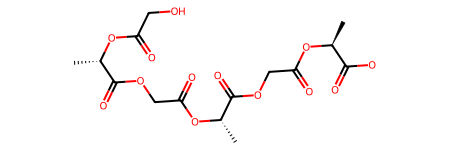

In [12]:
#Build a short linear chain using Swiftpol
from swiftpol import build
chain = build.build_linear_copolymer(sequence = 'ABABAB', monomer_a_smiles = 'C[C@@H](C(=O)[OH])O', monomer_b_smiles = 'OC(=O)CO')[0]
chain

In [13]:
#Assign charges to the chain using Espaloma Charge
from swiftpol import parameterize
import warnings
warnings.filterwarnings('ignore')
parameterize.print_polymer_charges(polymer = chain, charge_scheme='espaloma')

array([ 9.66780111e-02, -4.89754111e-01,  7.82715082e-01,  7.54409850e-01,
       -1.34297669e-01, -4.66306865e-01, -5.54364026e-01, -7.33117573e-04,
        7.77123094e-01, -4.96664405e-01, -5.82999945e-01,  9.48171839e-02,
        7.54409909e-01, -1.34297669e-01, -4.66306865e-01, -5.54364026e-01,
       -7.33117573e-04,  7.77123094e-01, -4.94031519e-01, -5.82999945e-01,
        9.09777433e-02,  8.01334977e-01, -1.31069779e-01, -5.08667111e-01,
       -5.43020368e-01, -1.82928820e-03, -6.75435662e-01, -6.55341148e-01,
        1.13536119e-01,  7.87098259e-02,  7.87098259e-02,  7.87098259e-02,
        1.24006629e-01,  1.24006629e-01,  1.13536119e-01,  7.87098259e-02,
        7.87098259e-02,  7.87098259e-02,  1.24006629e-01,  1.24006629e-01,
        1.16298944e-01,  7.87098259e-02,  7.87098259e-02,  7.87098259e-02,
        9.41646993e-02,  9.41646993e-02,  4.05642539e-01,  4.01869833e-01],
      dtype=float32)

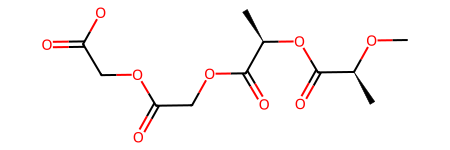

In [14]:
#Build a PLGA chain using Ring Opening Polymerisation
polymer = build.build_PLGA_ring(sequence = 'LLGG', terminal='ester')[0]
polymer

In [15]:
#Calculate the polydispersity index of the PLGA chain
PDI = build.PDI([polymer])[0]
print('PDI = ', PDI)

PDI =  1.0


In [ ]:
#Calculate the blockiness of the sequence
mean_blockiness, G_block_length, L_block_length = build.blockiness_calc(sequence='LLGG')
print("Average chain blockiness =", round(mean_blockiness,1))
print("G Block length =", round(G_block_length))
print("L Block length =", round(L_block_length))

## Ensemble Build

In [18]:
#Create a system
x = build.PLGA_system(80, 70, 1.0, 'ester', 6)
print('Actual lactide conc. = ', round(x.lactide_actual,2))
print('length range = ', x.min_length, '-', x.max_length)
print("Polydispersity Index = ", round(x.PDI,3))
print("Average chain blockiness =", x.mean_blockiness)

System built!, size = 6
Actual lactide conc. =  81.64
length range =  69 - 70
Polydispersity Index =  1.67
Average chain blockiness = 1.0


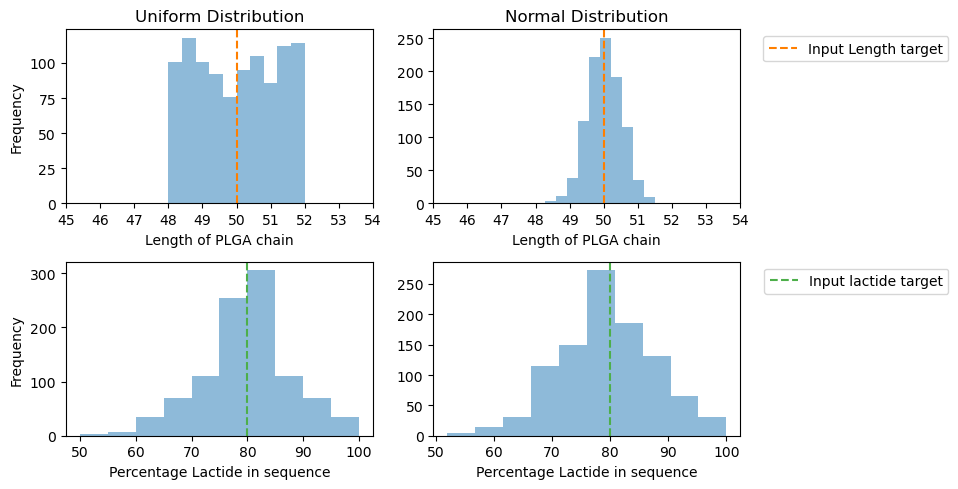

In [16]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
# Effect of a normal distribution
perc_lactide_target, length_target, num_chains = 80, 50, 1000 # specify input parameters

#Generate lengths and sequences without a normal distribution applied
lengths_1 = []
lac_1 = []
chains_1 = []
for i in range(num_chains):
    length_actual = np.random.uniform(int(round(length_target*0.95)),int(round(length_target*1.05)))
    lengths_1.append(length_actual)
    sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
    actual_lac = sequence.count('L')
    lac_1.append((actual_lac/len(sequence)*100))
    chains_1.append(build.build_PLGA_ring(sequence=sequence, terminal ='hydroxyl')[0])


#Generate lengths and sequences with a normal distribution applied
lengths_2 = []
lac_2 = []
mw_list2 = []
chains_2 = []
for i in range(num_chains):
    length_actual = np.random.normal(length_target, 0.5)
    lengths_2.append(length_actual)
    sequence = reduce(lambda x, y: x + y, np.random.choice(['LL', 'GG'], size=(int(length_actual/2),), p=[perc_lactide_target/100,1-(perc_lactide_target/100)]))
    actual_lac = sequence.count('L')
    lac_2.append((actual_lac/len(sequence)*100))
    chains_2.append(build.build_PLGA_ring(sequence=sequence, terminal ='hydroxyl')[0])

#Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].hist(lengths_1, rwidth=1, alpha=0.5)
axs[0,0].set_xticks(range(int(round(length_target*0.9)),int(round(length_target*1.1))))
axs[0,0].set_xlabel('Length of PLGA chain')
axs[0,0].set_ylabel('Frequency')
axs[0,0].axvline(length_target, color='#ff7f00', linestyle='--', label='Input Length target')
axs[0,0].set_title('Uniform Distribution')

axs[0,1].hist(lengths_2, rwidth=1, alpha=0.5)
axs[0,1].set_xticks(range(int(round(length_target*0.9)),int(round(length_target*1.1))))
axs[0,1].set_xlabel('Length of PLGA chain')
axs[0,1].axvline(length_target, color='#ff7f00', linestyle='--', label='Input Length target')
axs[0,1].set_title('Normal Distribution')
axs[0,1].legend(bbox_to_anchor=(1.7, 1.0))

axs[1,0].hist(lac_1, alpha=0.5)
axs[1,0].set_xlabel('Percentage Lactide in sequence')
axs[1,0].set_ylabel('Frequency')
axs[1,0].axvline(perc_lactide_target, color='#4daf4a', linestyle='--', label='Input lactide target')

axs[1,1].hist(lac_2, alpha=0.5)
axs[1,1].set_xlabel('Percentage Lactide in sequence')
axs[1,1].axvline(perc_lactide_target, color='#4daf4a', linestyle='--', label='Input lactide target')

plt.legend(bbox_to_anchor=(1.7, 1.0))
plt.tight_layout()
plt.show()

## Resomer® LG 756 S

Building a [commerically available PLGA](https://www.sigmaaldrich.com/GB/en/product/aldrich/719927) molecule with input specification based on quality assurance parameters

Blockiness value from literature:
Sun J, et al. 2022 | Characterization of commercial PLGAs by NMR spectroscopy. Drug Deliv Transl Res. 


In [22]:
#Create a system
import time
start = time.process_time()
x = build.PLGA_system(75, 1200, 1.7, 'ester', 1)
end = time.process_time()
print('Actual lactide conc. = ', round(x.lactide_actual,2))
print('length = ', x.min_length)
print("Polydispersity Index = ", round(x.PDI,3))
print("Average chain blockiness =", round(x.mean_blockiness,1))
print("Average Molecular Weight =", x.mol_weight_average)
print("G Block length =", round(x.G_block_length))
print("L Block length =", round(x.L_block_length))
#Print time taken to build chain
time_elapsed = end - start
print('Build time -', time_elapsed)

System built!, size = 1
Actual lactide conc. =  71.67
length =  1200
Polydispersity Index =  1.0
Average chain blockiness = 1.6
Average Molecular Weight = 81692.06
G Block length = 3
L Block length = 8
Build time - 60.42895200000001


## Benchmarking

In [23]:
import seaborn as sns
#Colour blind friendly colour wheel
cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']
cb_wheel = sns.color_palette(palette=cb_color_cycle)    
sns.set_context('talk')
sns.set_palette(cb_wheel)

In [ ]:
import pandas as pd
df_length = pd.DataFrame()
te_length = []
#Create a system
for length in range (50, 1000):
    start = time.process_time()
    build.PLGA_system(75, length, 1.7, 'hydroxyl', 1)
    end = time.process_time()
    time_elapsed = end - start
    te_length.append(time_elapsed)
df_length['Length'] = range(50, 1000)
df_length['Time_elapsed'] = te_length
    
df_length.to_csv('Length_benchmark_75.csv')

System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
System built!, size = 1
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockiness calculation performed
Molecule is not a co-polymer, no blockin

In [ ]:
#Plot results and export
fig, axs = plt.subplots(1, figsize=(7.5, 5))
sns.lineplot(x = df_length['Length'], y=df_length['Time_elapsed'], palette='#ff7f00', ax=axs)
plt.xlabel('Chain length')
plt.ylabel('Time to build system of n=1 (s)')
plt.title('Benchmarking for ensemble build code, increasing chain length', size=18, wrap=True)
plt.tight_layout()
#plt.savefig('length_1000_plot_75')

In [ ]:
df_size = pd.DataFrame()
te_size = []

#Create a system
for size in range (10,250):
    start = time.process_time()
    build.PLGA_system(75, 50, 1.7, 'hydroxyl', size)
    end = time.process_time()
    time_elapsed = end - start
    te_size.append(time_elapsed)
df_size['size'] = range(10,250)
df_size['Time_elapsed'] = te_size
    
df_size.to_csv('size_benchmark_75.csv')

In [ ]:
sns.set_context('poster')
fig, axs = plt.subplots(1, figsize=(7.5, 5))
sns.lineplot(x = df_size['size'], y=df_size['Time_elapsed'], c='g', ax=axs)
plt.xlabel('System size', wrap=True, size=18)
plt.ylabel('Time to build system (s)', wrap=True, size=18)
plt.title('Ensemble Build Speed Benchmarking', size=18, wrap=True)
plt.tight_layout()
plt.show()
#fig.savefig('size_250_plot_75', dpi=500)